# Setup

In [981]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Activation, Dense
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt


In [982]:
from datetime import datetime

def toDate(ts):
    return datetime.fromtimestamp(float(ts)).date()

np.random.seed(7)

# Load the data

In [1519]:
rawData = pd.read_csv("~/data/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27.csv", parse_dates=True, date_parser=toDate, index_col="Timestamp")
rawData

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000


## Check data quality

In [984]:
# Count nulls
for col in rawData.columns:
    print(rawData[col].isna().sum())

0
0
0
0
0
0
0


In [1520]:
df = rawData
df.index.names = ["Date"]
df['Volume'] = pd.to_numeric(df['Volume_(Currency)'])

df.shape
df

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Volume
Date,,,,,,,,
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000,3.000000e+00
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000,3.000000e+00
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000,3.000000e+00
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000,3.000000e+00
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000,3.000000e+00
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000,3.000000e+00
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000,3.000000e+00
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000,3.000000e+00
2014-12-01,300.00,300.00,300.00,300.00,0.010000,3.000000e+00,300.000000,3.000000e+00


In [656]:
# Do we have all days?
expected_dates = pd.period_range(min(df.index.values), max(df.index.values))

In [657]:
i = 0
j = 0

A = df.index.values
B = expected_dates

while (i < A.shape[0] and j < B.shape[0]):
    date1 = pd.to_datetime(A[i]).date()
    date2 = B[j].to_timestamp().date()
    if (date1 == date2):
        i += 1
        j += 1
    elif (date1 < date2):
        i += 1
    else:
        print("Missing " + str(date1) + " " + str(date2))
        j += 1

Missing 2014-12-06 2014-12-05
Missing 2014-12-08 2014-12-07
Missing 2014-12-10 2014-12-09
Missing 2014-12-12 2014-12-11
Missing 2014-12-18 2014-12-13
Missing 2014-12-18 2014-12-14
Missing 2014-12-18 2014-12-15
Missing 2014-12-18 2014-12-16
Missing 2014-12-18 2014-12-17
Missing 2015-01-08 2014-12-19
Missing 2015-01-08 2014-12-20
Missing 2015-01-08 2014-12-21
Missing 2015-01-08 2014-12-22
Missing 2015-01-08 2014-12-23
Missing 2015-01-08 2014-12-24
Missing 2015-01-08 2014-12-25
Missing 2015-01-08 2014-12-26
Missing 2015-01-08 2014-12-27
Missing 2015-01-08 2014-12-28
Missing 2015-01-08 2014-12-29
Missing 2015-01-08 2014-12-30
Missing 2015-01-08 2014-12-31
Missing 2015-01-08 2015-01-01
Missing 2015-01-08 2015-01-02
Missing 2015-01-08 2015-01-03
Missing 2015-01-08 2015-01-04
Missing 2015-01-08 2015-01-05
Missing 2015-01-08 2015-01-06
Missing 2015-01-08 2015-01-07
Missing 2015-01-13 2015-01-09
Missing 2015-01-13 2015-01-10
Missing 2015-01-13 2015-01-11
Missing 2015-01-13 2015-01-12
Missing 20

In [658]:
df["Close"].max(axis = 0)

19891.99

# Preprocess the data

In [1521]:
historical_prices = df.resample('1D').agg({'Open': 'first', 
                                 'High': 'max', 
                                 'Low': 'min', 
                                 'Close': 'last',
                                 'Volume': 'sum'}).dropna()
historical_prices = historical_prices[['Close', 'Volume']]

number_of_days = historical_prices.shape[0]
historical_prices

,Close,Volume
Date,,
2014-12-01,370.00,1.036952e+04
2014-12-02,378.00,9.347988e+05
2014-12-03,378.00,2.376454e+04
2014-12-04,377.10,4.120110e+02
2014-12-06,378.00,5.670000e+00
2014-12-08,375.00,8.812510e+01
2014-12-10,360.50,7.585000e+00
2014-12-12,350.00,1.582789e+03
2014-12-18,340.00,6.850000e+02


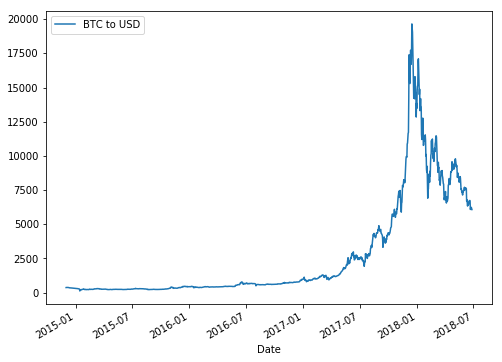

In [660]:
historical_prices.reset_index().plot(x="Date", y="Close", figsize=(8, 6), label="BTC to USD")

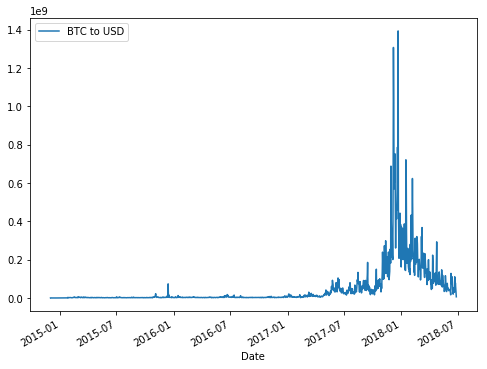

In [661]:
historical_prices.reset_index().plot(x="Date", y="Volume", figsize=(8, 6), label="BTC to USD")

# Split the dataset into training and testing set

In [851]:
test_split_point = int(number_of_days * 0.8)
train = historical_prices[:test_split_point] # 80% of the days are the train set 
test = historical_prices[test_split_point:] # 20% of the days are the test set

In [1403]:
train

,Close,Volume
Date,,
2014-12-01,370.00,1.036952e+04
2014-12-02,378.00,9.347988e+05
2014-12-03,378.00,2.376454e+04
2014-12-04,377.10,4.120110e+02
2014-12-06,378.00,5.670000e+00
2014-12-08,375.00,8.812510e+01
2014-12-10,360.50,7.585000e+00
2014-12-12,350.00,1.582789e+03
2014-12-18,340.00,6.850000e+02


In [1404]:
test

,Close,Volume
Date,,
2017-10-16,5716.89,4.850614e+07
2017-10-17,5571.34,5.027677e+07
2017-10-18,5587.95,9.113933e+07
2017-10-19,5711.71,5.143840e+07
2017-10-20,5989.10,9.413716e+07
2017-10-21,6091.28,8.705383e+07
2017-10-22,5936.92,6.119703e+07
2017-10-23,5868.29,9.268333e+07
2017-10-24,5508.01,1.001802e+08


# Prepare training and testing model

In [699]:
def normalize(dataset, window_len):
    return (dataset['Close'][window_len:].values/dataset['Close'][:-window_len].values)-1
    
def reverseNormalize(normalized, original, window_len):
    return (normalized + 1) * original[:-window_len]

def prepareInputAndOutput(dataset, window_len, norm_cols):
    inputs = []
    for i in range(len(dataset)-window_len):
        temp_set = dataset[i:(i+window_len)].copy()
        for col in norm_cols:
            temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1    
        inputs.append(temp_set)
        
    inputs = [np.array(inputs) for inputs in inputs]
    inputs = np.array(inputs)
    
    outputs = normalize(dataset, window_len)

    return (inputs, outputs)

# Choose (hyper) parameters

In [1393]:
window_len = 10
norm_cols = ["Close", "Volume"]
batch_size = 16
epochs = 15
units = 256 # Dimensionality

# Train model

In [1394]:
LSTM_training_inputs, LSTM_training_outputs = prepareInputAndOutput(train, window_len, norm_cols)

In [1395]:
model = Sequential()

model.add(LSTM(units,
               input_shape=(LSTM_training_inputs.shape[1], LSTM_training_inputs.shape[2]),
               return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))

model.compile(loss="mae", optimizer="adam")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 256)               265216    
_________________________________________________________________
dropout_80 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 257       
_________________________________________________________________
activation_56 (Activation)   (None, 1)                 0         
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________


In [1396]:
model.fit(LSTM_training_inputs,
          LSTM_training_outputs,
          epochs=epochs, 
          batch_size=batch_size, 
          verbose=True, 
          validation_split=0.05)

Train on 955 samples, validate on 51 samples
Epoch 1/15
955/955 [==============================] - 12s 12ms/step - loss: 0.0558 - val_loss: 0.0569
Epoch 2/15
955/955 [==============================] - 2s 2ms/step - loss: 0.0425 - val_loss: 0.0426
Epoch 3/15
955/955 [==============================] - 2s 2ms/step - loss: 0.0396 - val_loss: 0.0419
Epoch 4/15
955/955 [==============================] - 2s 2ms/step - loss: 0.0356 - val_loss: 0.0372
Epoch 5/15
955/955 [==============================] - 2s 2ms/step - loss: 0.0342 - val_loss: 0.0407
Epoch 6/15
955/955 [==============================] - 2s 2ms/step - loss: 0.0341 - val_loss: 0.0374
Epoch 7/15
955/955 [==============================] - 2s 2ms/step - loss: 0.0301 - val_loss: 0.0343
Epoch 8/15
955/955 [==============================] - 2s 2ms/step - loss: 0.0305 - val_loss: 0.0344
Epoch 9/15
955/955 [==============================] - 2s 2ms/step - loss: 0.0293 - val_loss: 0.0335
Epoch 10/15
955/955 [==============================] 

# Test model for unseen data

This test checks how good is the model in predicting future prices for the unseen historical data. If RMSE is small, the prediction is good

In [1397]:
LSTM_test_inputs, LSTM_test_outputs = prepareInputAndOutput(test, window_len, norm_cols)

In [1398]:
predicted_values = model.predict(LSTM_test_inputs)

In [1399]:
predicted = (np.transpose(predicted_values))

In [1400]:
actual = LSTM_test_outputs

# Plot normalized data

array(['2017-10-16T00:00:00.000000000', '2017-10-17T00:00:00.000000000',
       '2017-10-18T00:00:00.000000000', '2017-10-19T00:00:00.000000000',
       '2017-10-20T00:00:00.000000000', '2017-10-21T00:00:00.000000000',
       '2017-10-22T00:00:00.000000000', '2017-10-23T00:00:00.000000000',
       '2017-10-24T00:00:00.000000000', '2017-10-25T00:00:00.000000000',
       '2017-10-26T00:00:00.000000000', '2017-10-27T00:00:00.000000000',
       '2017-10-28T00:00:00.000000000', '2017-10-29T00:00:00.000000000',
       '2017-10-30T00:00:00.000000000', '2017-10-31T00:00:00.000000000',
       '2017-11-01T00:00:00.000000000', '2017-11-02T00:00:00.000000000',
       '2017-11-03T00:00:00.000000000', '2017-11-04T00:00:00.000000000',
       '2017-11-05T00:00:00.000000000', '2017-11-06T00:00:00.000000000',
       '2017-11-07T00:00:00.000000000', '2017-11-08T00:00:00.000000000',
       '2017-11-09T00:00:00.000000000', '2017-11-10T00:00:00.000000000',
       '2017-11-11T00:00:00.000000000', '2017-11-12

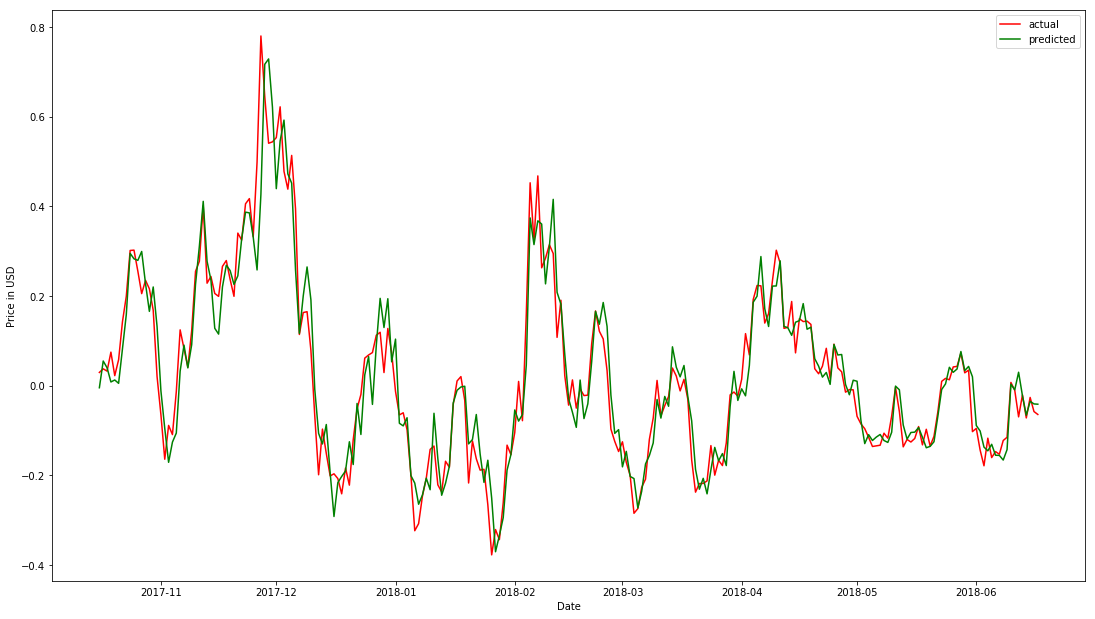

In [1459]:
def plotActualAndPredicted(X, actual, predicted):
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(18.5, 10.5)
    ax1.plot(X, actual, label="actual", color="red")
    ax1.plot(X, predicted, label="predicted", color="green")
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price in USD')
    plt.show()
    
plotActualAndPredicted(test.index.values[:-window_len], actual, predicted[0])

In [1460]:
rmse1 = np.sqrt(((predicted-actual) ** 2).mean())
rmse1

0.05962856019257979

# Plot de-normalized data

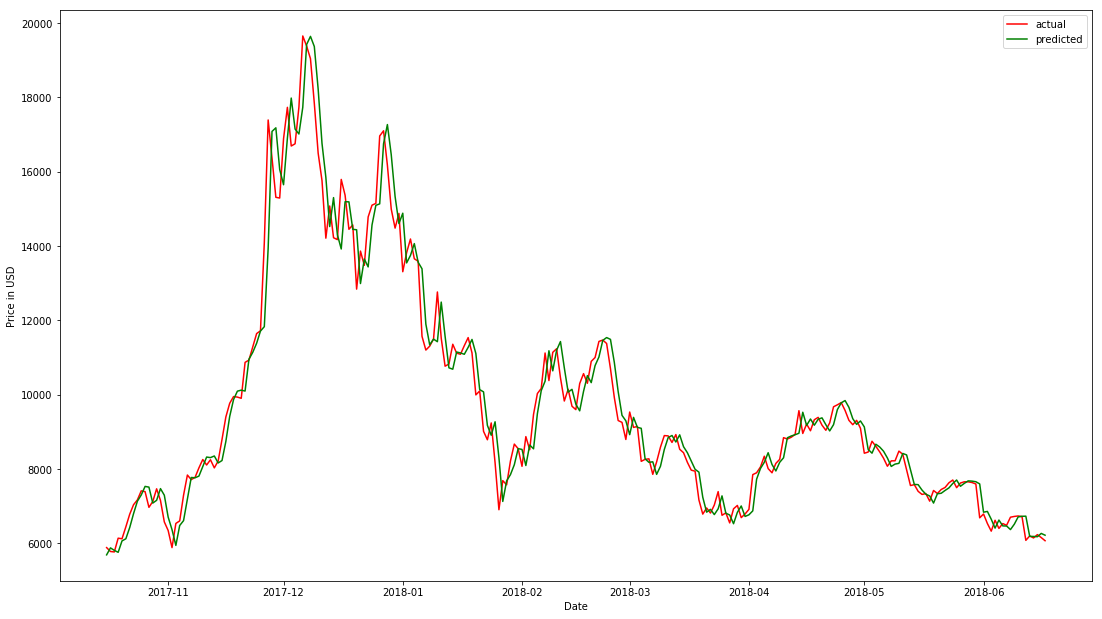

In [1461]:
denormalizedActual = reverseNormalize(actual, test["Close"].values, window_len)
denormalizedPredicted = reverseNormalize(predicted, test["Close"].values, window_len)

plotActualAndPredicted(test.index.values[:-window_len], denormalizedActual, denormalizedPredicted[0])

In [1354]:
rmse2 = np.sqrt(((denormalizedPredicted[0]-denormalizedActual) ** 2).mean())
rmse2

633.2998647747036

# Test model for completly random days

This test will use our model to predict something which cannot be predicted correctly, as the historical prices don't impact future prices - they are generated randomly.

In [1355]:
import random

random.seed(42)
startClose = 5716.89
startVolume = 4.850614e+07

random_walk = test.copy()

newPrices = []
newVolume = []

for i in range(random_walk.shape[0]):
    startClose = startClose * (1.0 + random.randint(-10, 10) / 50.0)
    startVolume = startVolume * (1.0 + random.randint(-10, 10) / 50.0)

    newPrices.append(startClose)
    newVolume.append(startVolume)

random_walk['Close'] = newPrices
random_walk['Volume'] = newVolume

random_walk

,Close,Volume
Date,,
2017-10-16,6860.268000,4.171528e+07
2017-10-17,5488.214400,4.004667e+07
2017-10-18,5158.921536,3.764387e+07
2017-10-19,4539.850952,3.237373e+07
2017-10-20,5175.430085,2.719393e+07
2017-10-21,6003.498899,2.882557e+07
2017-10-22,4922.869097,2.306045e+07
2017-10-23,4135.210041,2.121562e+07
2017-10-24,3887.097439,2.376149e+07


In [1356]:
LSTM_random_walk_inputs, LSTM_random_walk_outputs = prepareInputAndOutput(random_walk, window_len, norm_cols)

In [1357]:
predicted_values = model.predict(LSTM_random_walk_inputs)

In [1358]:
predicted = (np.transpose(predicted_values))

In [1359]:
actual = LSTM_random_walk_outputs

/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:504: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


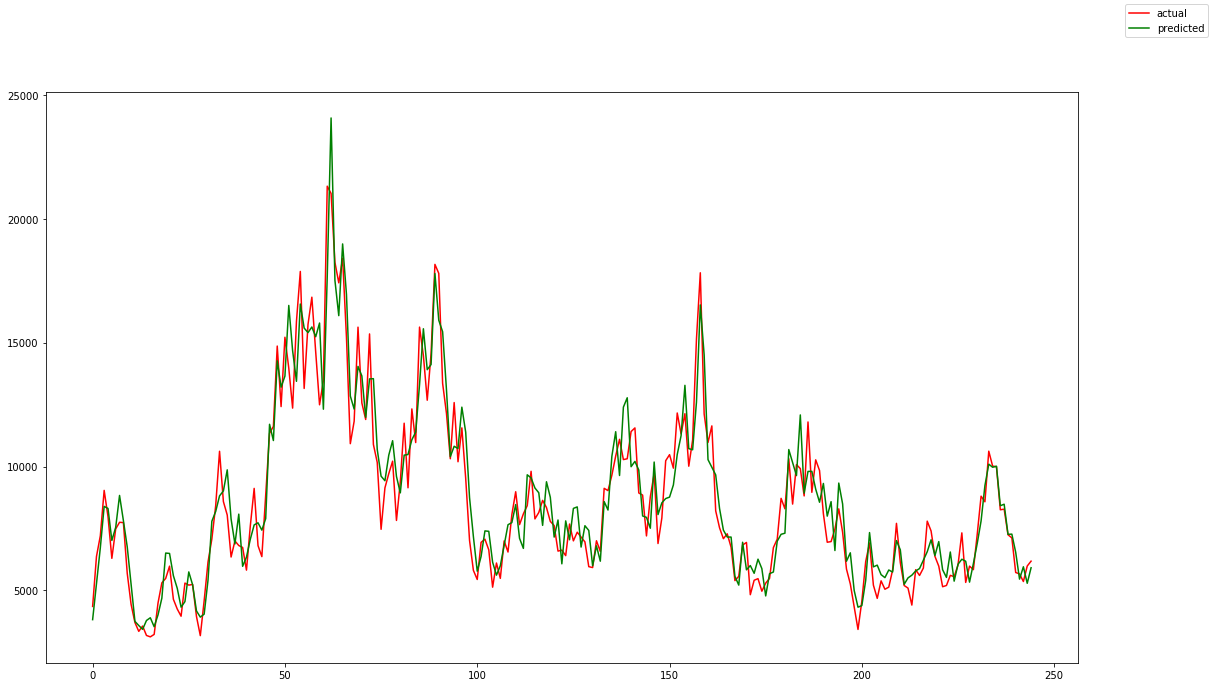

In [1360]:
denormalizedRandomWalkActual = reverseNormalize(actual, test["Close"].values, window_len)
denormalizedRandomWalkPredicted = reverseNormalize(predicted, test["Close"].values, window_len)

plotActualAndPredicted(denormalizedRandomWalkActual, denormalizedRandomWalkPredicted[0])

In [1361]:
rmse3 = np.sqrt(((denormalizedRandomWalkPredicted[0]-denormalizedRandomWalkActual) ** 2).mean())
rmse3

1096.5136872816247

# Benchmark 1 - test using random-walk model

/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:504: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


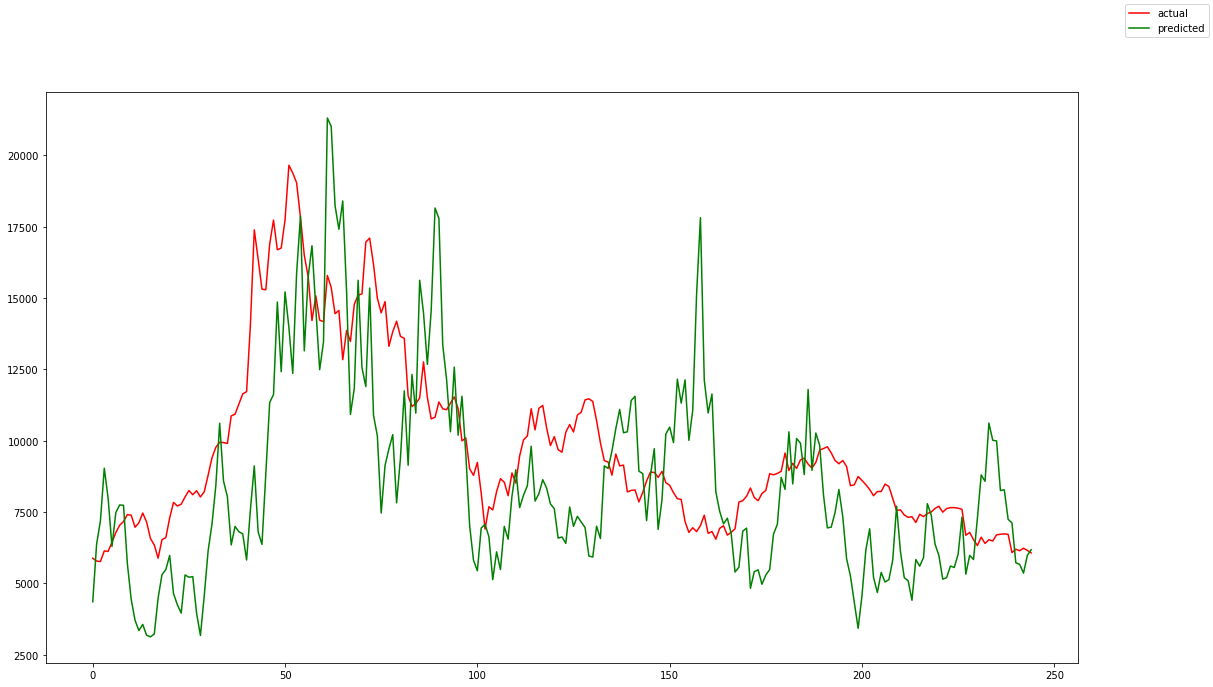

In [1362]:
plotActualAndPredicted(denormalizedActual, denormalizedRandomWalkActual)

In [1363]:
rmse3 = np.sqrt(((denormalizedActual-denormalizedRandomWalkActual) ** 2).mean())
rmse3

3184.256588699052

# Benchmark 2 - test using linear regression model

In [1501]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [1502]:
X = train.index.values.reshape(-1, 1).astype('float64')
X

array([[1.4173920e+18],
       [1.4174784e+18],
       [1.4175648e+18],
       ...,
       [1.5078528e+18],
       [1.5079392e+18],
       [1.5080256e+18]])

In [1503]:
X_test = test.index.values.reshape(-1, 1).astype('float64')
X_test

array([[1.5081120e+18],
       [1.5081984e+18],
       [1.5082848e+18],
       [1.5083712e+18],
       [1.5084576e+18],
       [1.5085440e+18],
       [1.5086304e+18],
       [1.5087168e+18],
       [1.5088032e+18],
       [1.5088896e+18],
       [1.5089760e+18],
       [1.5090624e+18],
       [1.5091488e+18],
       [1.5092352e+18],
       [1.5093216e+18],
       [1.5094080e+18],
       [1.5094944e+18],
       [1.5095808e+18],
       [1.5096672e+18],
       [1.5097536e+18],
       [1.5098400e+18],
       [1.5099264e+18],
       [1.5100128e+18],
       [1.5100992e+18],
       [1.5101856e+18],
       [1.5102720e+18],
       [1.5103584e+18],
       [1.5104448e+18],
       [1.5105312e+18],
       [1.5106176e+18],
       [1.5107040e+18],
       [1.5107904e+18],
       [1.5108768e+18],
       [1.5109632e+18],
       [1.5110496e+18],
       [1.5111360e+18],
       [1.5112224e+18],
       [1.5113088e+18],
       [1.5113952e+18],
       [1.5114816e+18],
       [1.5115680e+18],
       [1.511654

In [1504]:
Y_test = test["Close"].values.reshape(-1, 1)
Y_test

array([[ 5716.89],
       [ 5571.34],
       [ 5587.95],
       [ 5711.71],
       [ 5989.1 ],
       [ 6091.28],
       [ 5936.92],
       [ 5868.29],
       [ 5508.01],
       [ 5691.02],
       [ 5886.73],
       [ 5781.8 ],
       [ 5770.01],
       [ 6140.01],
       [ 6124.16],
       [ 6445.01],
       [ 6783.69],
       [ 7039.98],
       [ 7170.01],
       [ 7412.55],
       [ 7392.  ],
       [ 6969.76],
       [ 7126.63],
       [ 7467.96],
       [ 7156.  ],
       [ 6577.62],
       [ 6346.7 ],
       [ 5886.35],
       [ 6535.87],
       [ 6605.  ],
       [ 7294.  ],
       [ 7838.53],
       [ 7714.71],
       [ 7777.01],
       [ 8031.82],
       [ 8256.01],
       [ 8109.  ],
       [ 8250.  ],
       [ 8031.16],
       [ 8215.01],
       [ 8795.5 ],
       [ 9401.11],
       [ 9768.71],
       [ 9949.  ],
       [ 9935.98],
       [ 9903.  ],
       [10869.84],
       [10930.24],
       [11290.  ],
       [11643.98],
       [11718.35],
       [14090.  ],
       [1739

In [1505]:
type(X)

numpy.ndarray

In [1506]:
lr.fit(X, train["Close"].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [1507]:
print(lr.intercept_)
print(lr.coef_)

-47484.432815242486
[3.30821038e-14]


In [1508]:
pred = lr.predict(X_test.astype('float'))

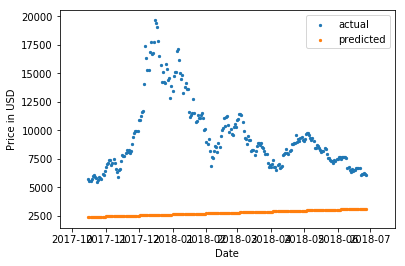

In [1509]:
plt.scatter(pd.to_datetime(X_test.transpose()[0]),Y_test,s=5, label='actual')
plt.scatter(pd.to_datetime(X_test.transpose()[0]),pred,s=5, label='predicted')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

In [1510]:
rmse4 = np.sqrt(((Y_test-pred) ** 2).mean())
rmse4

7443.968370662284

In [1511]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
trainX, testX, trainY, testY = train_test_split(X, train["Close"].values)

In [1512]:
pred = lr.predict(testX.astype('float'))

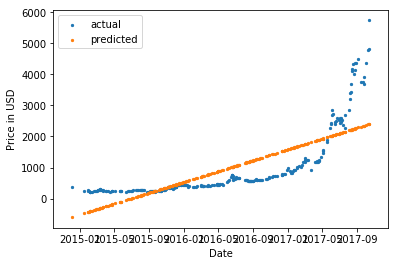

In [1513]:
plt.scatter(pd.to_datetime(testX.transpose()[0]),testY,s=5, label='actual')
plt.scatter(pd.to_datetime(testX.transpose()[0]),pred,s=5, label='predicted')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()


In [1479]:
rmse5 = np.sqrt(((testY-pred) ** 2).mean())
rmse5

703.5186214059062

# Benchmark 3 - test using moving averages

In [1378]:
data = historical_prices

short_rolling = data.rolling(window=20).mean()
long_rolling = data.rolling(window=100).mean()

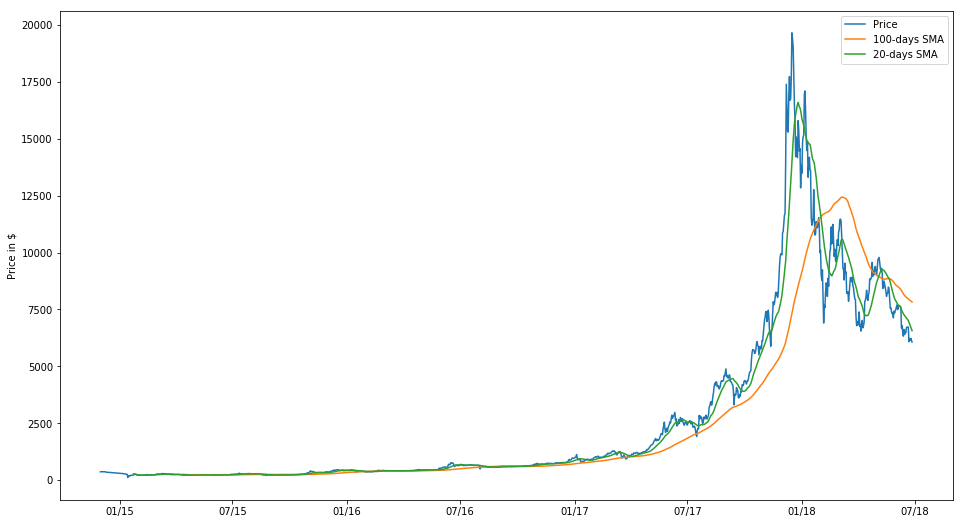

In [1379]:
import matplotlib.dates as mdates

start_date = data.index.values[0]
end_date = data.index.values[-1]

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'Close'], label='Price')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'Close'], label = '100-days SMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'Close'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
my_year_month_fmt = mdates.DateFormatter('%m/%y')
ax.xaxis.set_major_formatter(my_year_month_fmt)

In [1380]:
actual = data[-testY.shape[0]:]["Close"].values.reshape(-1, 1)
pred = long_rolling[-testY.shape[0]:]["Close"].values.reshape(-1, 1)
rmse6 = np.sqrt(((actual-pred) ** 2).mean())
rmse6

3758.703786460806

In [1381]:
pred = short_rolling[-testY.shape[0]:]["Close"].values.reshape(-1, 1)
rmse7 = np.sqrt(((actual-pred) ** 2).mean())
rmse7

1665.7130075038074

In [1517]:
LSTM_test_inputs[-1]

array([[ 0.        ,  0.        ],
       [ 0.03348399,  1.70155251],
       [ 0.03668271,  1.03210327],
       [ 0.03864664,  1.20436121],
       [ 0.03603988,  0.50781564],
       [-0.06249287,  4.52590627],
       [-0.04420855,  0.88545736],
       [-0.05248976,  2.93753123],
       [-0.03877305,  1.84774758],
       [-0.05093433,  0.8014408 ]])